In [72]:
### >>> Firstly we need to do Data Preparation.

# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import squarify
from prophet import Prophet
from sklearn.metrics import mean_squared_error
# Load the datasets (assuming they've already been loaded previously)
customers_df = pd.read_csv('Customers.csv')
orders_df = pd.read_csv('Orders.csv')
products_df = pd.read_csv('Products.csv')

# Set some common styles for visualization
sns.set(style="whitegrid")


In [2]:
# Check for missing data in both files
customer_missing_data = customers_df.isnull().sum()
product_missing_data = products_df.isnull().sum()
order_missing_data = orders_df.isnull().sum()
# Display the first few rows and columns to understand the structure
customer_missing_data, product_missing_data, order_missing_data

(Customer ID      0
 Customer Name    0
 Segment          0
 dtype: int64,
 Product ID        0
 Category          0
 Sub-Category      0
 Product Name      0
 New Product ID    0
 dtype: int64,
 Order ID           0
 Order Date         0
 Ship Date          0
 Ship Mode          0
 Customer ID        0
 Country            0
 City               0
 State              0
 Postal Code       11
 Region             0
 New Product ID     0
 Sales              0
 dtype: int64)

In [3]:
# Convert 'Order Date' to datetime
orders_df['Order Date'] = pd.to_datetime(orders_df['Order Date'], format='%d/%m/%Y')

# Merge orders with products on 'Product ID'
orders_products_merged = pd.merge(orders_df, products_df, on='New Product ID', how='inner')

# Merge with customers on 'Customer ID'
full_data = pd.merge(orders_products_merged, customers_df, on='Customer ID', how='inner')

# Create a new column for 'Year-Month' for aggregation
full_data['Year-Month'] = full_data['Order Date'].dt.to_period('M')

# Aggregate sales by 'Year-Month' and 'Product Name' or 'Category'
time_series_data = full_data.groupby(['Year-Month', 'Category'])['Sales'].sum().reset_index()

# Check the first few rows of the prepared dataset
print(time_series_data.head())

  Year-Month         Category     Sales
0    2015-01        Furniture  6217.277
1    2015-01  Office Supplies  4845.140
2    2015-01       Technology  3143.290
3    2015-02        Furniture  1839.658
4    2015-02  Office Supplies  1071.724


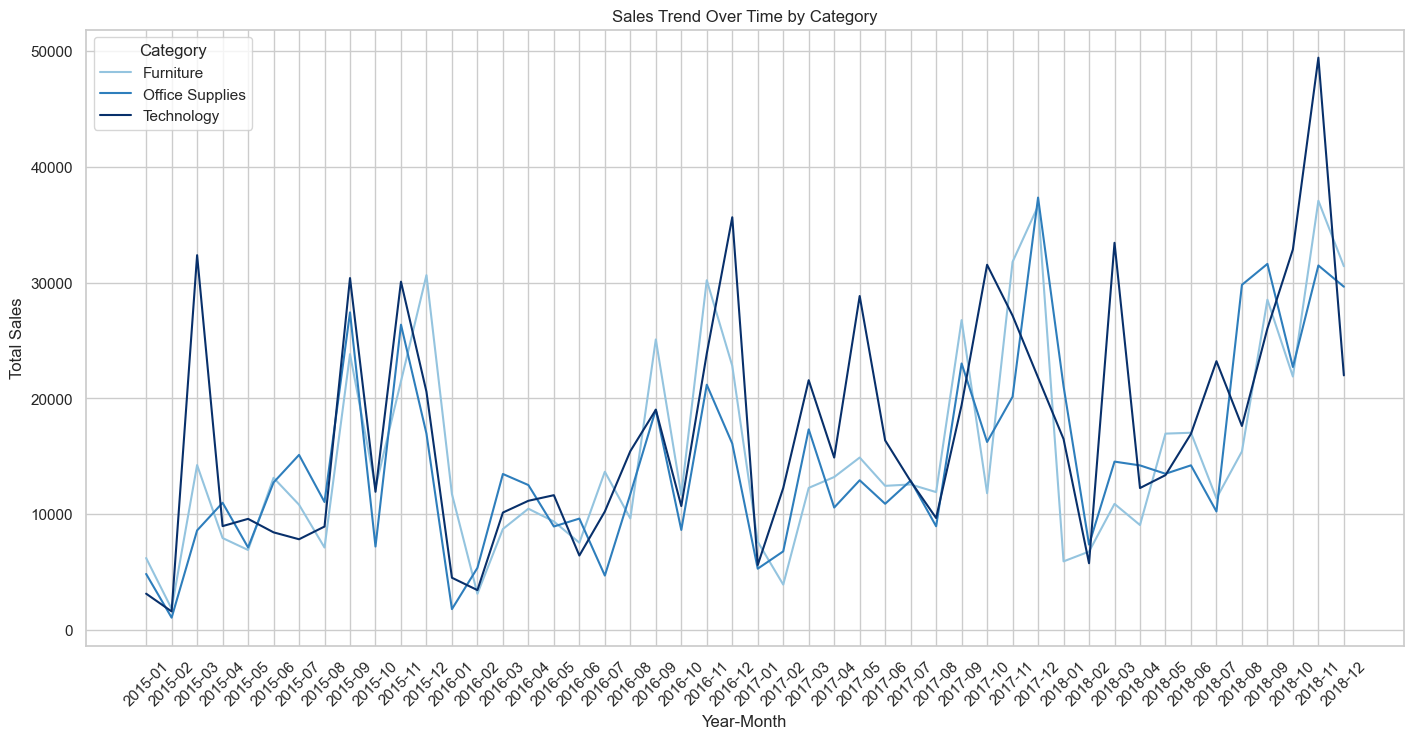

In [75]:
### >>> secondly Exploratory Data Analysis (EDA).

# Line plot for sales trends over time by category
# Set the size of the plot
plt.figure(figsize=(17, 8))  # Adjust the width and height as needed

# Get unique categories and the number of categories
unique_categories = time_series_data['Category'].unique()
num_categories = len(unique_categories)

# Generate blue shades for each category
colors = cm.Blues(np.linspace(0.4, 1, num_categories))  # Adjust the range to get lighter or darker shades

# Plot sales trends over time for each category
for i, category in enumerate(unique_categories):
    category_data = time_series_data[time_series_data['Category'] == category]
    plt.plot(category_data['Year-Month'].astype(str), category_data['Sales'], label=category, color=colors[i])

plt.xticks(rotation=45)
plt.title('Sales Trend Over Time by Category')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.legend(title='Category')  # Add a title to the legend
plt.show()

In [5]:
### >>> Thirdly, discover the data and ask some questions necessary for analysis.

# What is the total number of unique customers?
# Get the total number of unique customers
total_customers = customers_df['Customer ID'].nunique()
print(f"Total unique customers: {total_customers}")


Total unique customers: 793


In [6]:
# How are the customers segmented? (e.g., Consumer, Corporate, etc.)
# Get the distribution of customers by segment
customer_segment_distribution = customers_df['Segment'].value_counts()
print(customer_segment_distribution)


Consumer       409
Corporate      236
Home Office    148
Name: Segment, dtype: int64


In [7]:
# Which customer segment has the most orders? (Repeated)
# Merge customers with orders to count orders per segment
orders_customers_merged = pd.merge(orders_df, customers_df, on='Customer ID')
segment_order_count = orders_customers_merged['Segment'].value_counts()
print(segment_order_count)

Consumer       5101
Corporate      2953
Home Office    1746
Name: Segment, dtype: int64


In [8]:
# Count the unique orders per customer segment using 'Order ID'
segment_order_count = orders_customers_merged.groupby('Segment')['Order ID'].nunique().sort_values(ascending=False)

# Display the number of unique orders per customer segment
print(segment_order_count)

Segment
Consumer       2537
Corporate      1491
Home Office     894
Name: Order ID, dtype: int64


In [9]:
# Are there any regions or states with a significantly higher concentration of customers?
# Count customers per region and state
customer_region_count = customers_df['Segment'].groupby(orders_df['State']).count().sort_values(ascending=False)
print(customer_region_count.head(10))  # Top 10 states with the most customers

State
California      146
New York         96
Texas            76
Pennsylvania     51
Illinois         51
Ohio             49
Florida          34
Michigan         33
Washington       32
Colorado         30
Name: Segment, dtype: int64


In [10]:
# How many unique orders are there in the dataset?
# Count unique orders
unique_orders = orders_df['Order ID'].nunique()
print(f"Total unique orders: {unique_orders}")


Total unique orders: 4922


In [11]:
# What is the distribution of order dates over time? Are there specific months or seasons where orders peak?
# Convert 'Order Date' to datetime and extract month
orders_df['Order Date'] = pd.to_datetime(orders_df['Order Date'], format='%d/%m/%Y')
orders_df['Order Month'] = orders_df['Order Date'].dt.month

# Count orders per month
monthly_order_distribution = orders_df['Order Month'].value_counts().sort_index()
print(monthly_order_distribution)

1      366
2      297
3      680
4      657
5      725
6      691
7      697
8      693
9     1354
10     809
11    1449
12    1382
Name: Order Month, dtype: int64


In [12]:
# What is the most common repeated shipping mode used by customers?
# Count the shipping mode frequency
shipping_mode_count = orders_df['Ship Mode'].value_counts()
print(shipping_mode_count)

Standard Class    5859
Second Class      1902
First Class       1501
Same Day           538
Name: Ship Mode, dtype: int64


In [13]:
# Assuming 'Order ID' is the unique identifier for each order
unique_orders_per_ship_mode = orders_df.groupby('Ship Mode')['Order ID'].nunique()
print(unique_orders_per_ship_mode)

Ship Mode
First Class        772
Same Day           261
Second Class       944
Standard Class    2945
Name: Order ID, dtype: int64


In [14]:
# What regions have the highest number of orders?
# Count orders by region (repeated)
region_order_count = orders_df['Region'].value_counts()
print(region_order_count)

West       3140
East       2785
Central    2277
South      1598
Name: Region, dtype: int64


In [15]:
# Assuming 'Order ID' is the unique identifier for each order
unique_orders_per_region = orders_df.groupby('Region')['Order ID'].nunique()
print(unique_orders_per_region)

Region
Central    1156
East       1369
South       810
West       1587
Name: Order ID, dtype: int64


In [16]:
# Are there any trends in sales based on customer locations (city, state, region)?
# Calculate sales by region
sales_by_region = orders_df.groupby('Region')['Sales'].sum().sort_values(ascending=False)
print(sales_by_region)

Region
West       710219.6845
East       669518.7260
Central    492646.9132
South      389151.4590
Name: Sales, dtype: float64


In [17]:
# What is the average order value? Are there any notable differences across regions, states, or cities?
# Calculate average order value per order
average_order_value = orders_df.groupby('Order ID')['Sales'].sum().mean()
print(f"Average order value: {average_order_value:.2f}")

# Calculate average order value by region
average_order_value_by_region = orders_df.groupby('Region')['Sales'].mean().sort_values(ascending=False)
print(average_order_value_by_region)

Average order value: 459.48
Region
South      243.524067
East       240.401697
West       226.184613
Central    216.357889
Name: Sales, dtype: float64


In [18]:
# Calculate average order value by state
average_order_value_by_state = orders_df.groupby('State')['Sales'].mean().sort_values(ascending=False)
print(average_order_value_by_state.head(10))

State
Wyoming         1603.136000
Vermont          811.760909
Nevada           428.951333
Rhode Island     409.545927
Montana          372.623467
Indiana          360.877037
Missouri         336.441667
Minnesota        335.541011
Alabama          319.846557
Virginia         315.342500
Name: Sales, dtype: float64


In [19]:
# Calculate average order value by City
average_order_value_by_City = orders_df.groupby('City')['Sales'].mean().sort_values(ascending=False)
print(average_order_value_by_City.head(10))

City
Jamestown       2354.395000
Cheyenne        1603.136000
Bellingham      1263.413333
Independence    1208.685000
Burbank         1082.386000
Buffalo          906.349600
Burlington       866.723280
Beverly          861.063333
Lafayette        860.147586
Sparks           853.986667
Name: Sales, dtype: float64


In [20]:
# Which customers have placed the largest orders (by value or quantity)?
# Sum the sales for each customer
# Merge orders_df with customers_df to get Customer Names
orders_with_customers = pd.merge(orders_df, customers_df, on='Customer ID')

# Sum the sales for each customer and include their names
customer_order_value = orders_with_customers.groupby(['Customer ID', 'Customer Name'])['Sales'].sum().sort_values(ascending=False)

# Display the top 10 customers by order value
print(customer_order_value.head(10))

Customer ID  Customer Name     
SM-20320     Sean Miller           25043.050
TC-20980     Tamara Chand          19052.218
RB-19360     Raymond Buch          15117.339
TA-21385     Tom Ashbrook          14595.620
AB-10105     Adrian Barton         14473.571
KL-16645     Ken Lonsdale          14175.229
SC-20095     Sanjit Chand          14142.334
HL-15040     Hunter Lopez          12873.298
SE-20110     Sanjit Engle          12209.438
CC-12370     Christopher Conant    12129.072
Name: Sales, dtype: float64


In [22]:
# Count the occurrences of each product being ordered
most_ordered_products = full_data.groupby(['New Product ID', 'Category', 'Sub-Category']).size().sort_values(ascending=False).head(10)
# Print the top 10 most ordered products with their categories and sub-categories
print(most_ordered_products)

New Product ID                Category         Sub-Category
FUR-CH-10002647-Situations C  Furniture        Chairs          15
TEC-AC-10003628-Logitech 910  Technology       Accessories     15
OFF-BI-10001524-GBC Premium   Office Supplies  Binders         14
FUR-CH-10003774-Global Wood   Furniture        Chairs          14
FUR-CH-10002880-Global High-  Furniture        Chairs          14
TEC-AC-10003038-Kingston Dig  Technology       Accessories     13
OFF-BI-10004970-ACCOHIDE 3-R  Office Supplies  Binders         13
OFF-BI-10004140-Avery Non-St  Office Supplies  Binders         13
OFF-BI-10000977-Ibico Plasti  Office Supplies  Binders         13
OFF-BI-10000301-GBC Instant   Office Supplies  Binders         13
dtype: int64


In [23]:

# Calculate total sales for each product
product_sales = full_data.groupby(['New Product ID', 'Category', 'Sub-Category'])['Sales'].sum()

# Sort products based on total sales in descending order
top_selling_products = product_sales.sort_values(ascending=False)

# Display the product with the highest sales
print("Top Selling Products:\n", top_selling_products.head(10))

Top Selling Products:
 New Product ID                Category         Sub-Category
TEC-CO-10004722-Canon imageC  Technology       Copiers         61599.824
OFF-BI-10003527-Fellowes PB5  Office Supplies  Binders         27453.384
TEC-MA-10002412-Cisco TelePr  Technology       Machines        22638.480
FUR-CH-10002024-HON 5400 Ser  Furniture        Chairs          21870.576
OFF-BI-10001359-GBC DocuBind  Office Supplies  Binders         19823.479
OFF-BI-10000545-GBC Ibimaste  Office Supplies  Binders         19024.500
TEC-CO-10001449-Hewlett Pack  Technology       Copiers         18839.686
TEC-MA-10001127-HP Designjet  Technology       Machines        18374.895
OFF-BI-10004995-GBC DocuBind  Office Supplies  Binders         17965.068
OFF-SU-10000151-High Speed A  Office Supplies  Supplies        17030.312
Name: Sales, dtype: float64


In [24]:
# How many unique products are offered?
# Count unique products
unique_products = products_df['New Product ID'].nunique()
print(f"Total unique products: {unique_products}")

Total unique products: 1893


In [25]:
# Which product categories generate the highest sales?
# Merge products with orders to calculate total sales per category
orders_products_merged = pd.merge(orders_df, products_df, on='New Product ID')
category_sales = orders_products_merged.groupby('Category')['Sales'].sum().sort_values(ascending=False)
print(category_sales)

Category
Technology         827455.8730
Furniture          728658.5757
Office Supplies    705422.3340
Name: Sales, dtype: float64


In [26]:
# What are the top-selling products within each sub-category?
# Calculate total sales per sub-category
sub_category_sales = orders_products_merged.groupby('Sub-Category')['Sales'].sum().sort_values(ascending=False)
print(sub_category_sales.head())  # Top-selling sub-categories

Sub-Category
Phones     327782.448
Chairs     322822.731
Storage    219343.392
Tables     202810.628
Binders    200028.785
Name: Sales, dtype: float64


In [27]:
# What is the total sales revenue generated across all orders?
# Sum total sales
total_sales_revenue = orders_df['Sales'].sum()
print(f"Total sales revenue: {total_sales_revenue:.2f}")

Total sales revenue: 2261536.78


In [28]:
# How do sales vary by customer segment?
# Calculate sales by customer segment
sales_by_segment = orders_customers_merged.groupby('Segment')['Sales'].sum().sort_values(ascending=False)

# Printing each segment with its total sales as an integer
for segment, sales in sales_by_segment.items():
    print(f"{segment}: {int(sales)}")

Consumer: 1148060
Corporate: 688494
Home Office: 424982


In [29]:
# What is the frequency of orders per customer?  (Repetaed)
# Merge orders with customers to get the Customer Name
orders_customers_merged = pd.merge(orders_df, customers_df, on='Customer ID')

# Count the number of orders per customer
orders_per_customer = orders_customers_merged.groupby(['Customer ID', 'Customer Name']).size().sort_values(ascending=False)

# Display the top customers with the most orders
print(orders_per_customer.head(10))

Customer ID  Customer Name      
WB-21850     William Brown          35
PP-18955     Paul Prost             34
MA-17560     Matt Abelman           34
JL-15835     John Lee               33
CK-12205     Chloris Kastensmidt    32
SV-20365     Seth Vernon            32
JD-15895     Jonathan Doherty       32
AP-10915     Arthur Prichep         31
ZC-21910     Zuschuss Carroll       31
EP-13915     Emily Phan             31
dtype: int64


In [30]:
orders_per_customer = orders_customers_merged.groupby(['Customer ID', 'Customer Name'])['Order ID'].nunique().sort_values(ascending=False)

# Display the top customers with the most unique orders
print(orders_per_customer.head(10))

Customer ID  Customer Name      
EP-13915     Emily Phan             17
CK-12205     Chloris Kastensmidt    13
ZC-21910     Zuschuss Carroll       13
JE-15745     Joel Eaton             13
PG-18820     Patrick Gardner        13
HG-14965     Henry Goldwyn          12
CL-12565     Clay Ludtke            12
DK-12835     Damala Kotsonis        12
SJ-20125     Sanjit Jacobs          12
NS-18640     Noel Staavos           12
Name: Order ID, dtype: int64


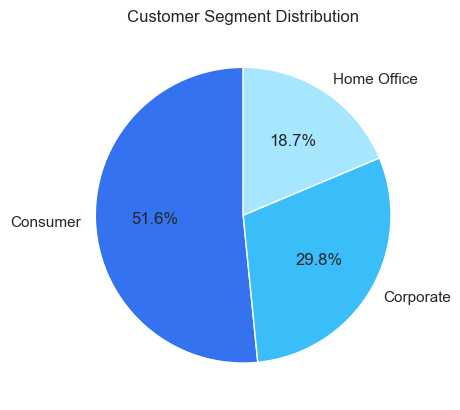

In [54]:
# Pie chart of customer segments
customers_df['Segment'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#3572EF','#3ABEF9','#A7E6FF'])
plt.title('Customer Segment Distribution')
plt.ylabel('')
plt.show()


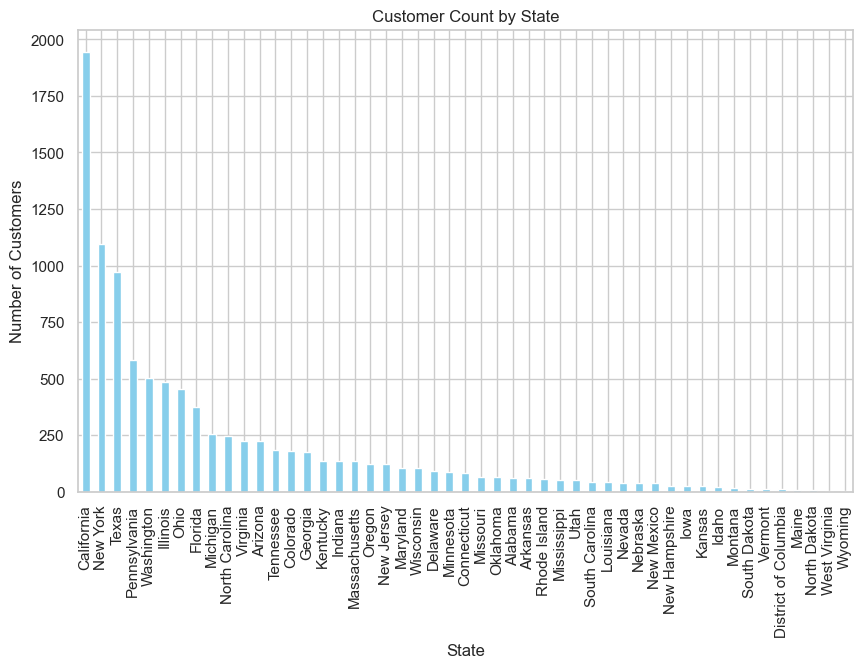

In [32]:
# Bar chart for customers by state
orders_df['State'].value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Customer Count by State')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.show()


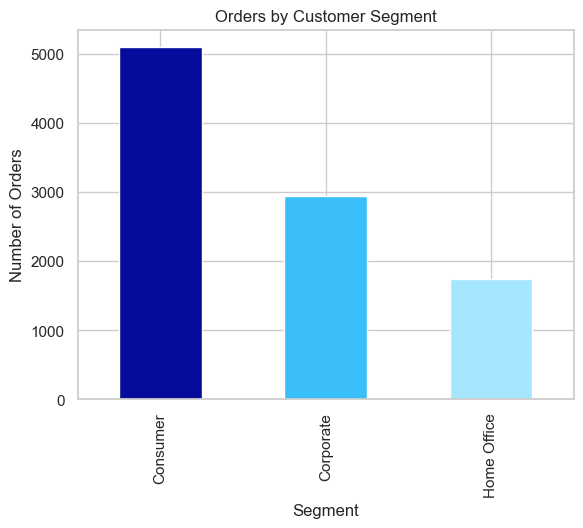

In [55]:
# Stacked bar chart for number of orders by customer segment
orders_customers_merged.groupby(['Segment']).size().plot(kind='bar', stacked=True, color=['#050C9C','#3ABEF9','#A7E6FF'])
plt.title('Orders by Customer Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Orders')
plt.show()


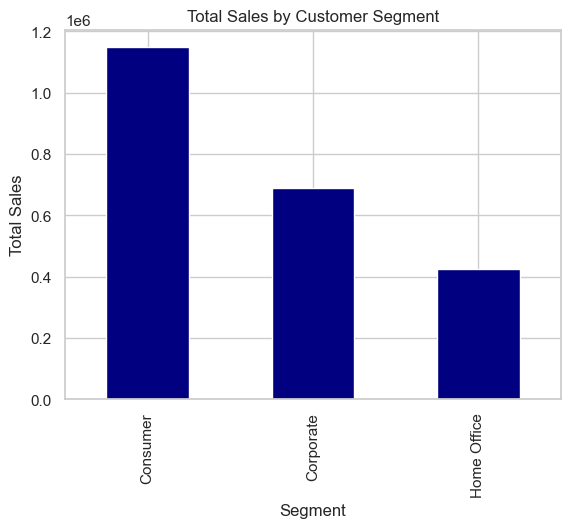

In [56]:
# Bar chart for average sales per customer segment
orders_customers_merged.groupby('Segment')['Sales'].sum().plot(kind='bar', color='Navy')
plt.title('Total Sales by Customer Segment')
plt.ylabel('Total Sales')
plt.show()


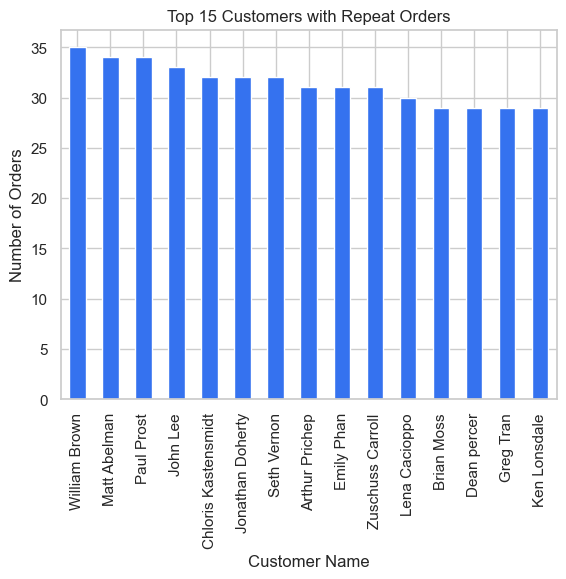

In [57]:
# Bar chart for top N customers with the most repeat orders
N = 15  # Choose the number of customers to display
filtered_orders_per_customer = orders_customers_merged.groupby('Customer Name').size()
top_customers = filtered_orders_per_customer[filtered_orders_per_customer > 1].nlargest(N)

# Plot the top N customers
top_customers.plot(kind='bar', color='#3572EF')
plt.title(f'Top {N} Customers with Repeat Orders')
plt.xlabel('Customer Name') 
plt.ylabel('Number of Orders')
plt.show()


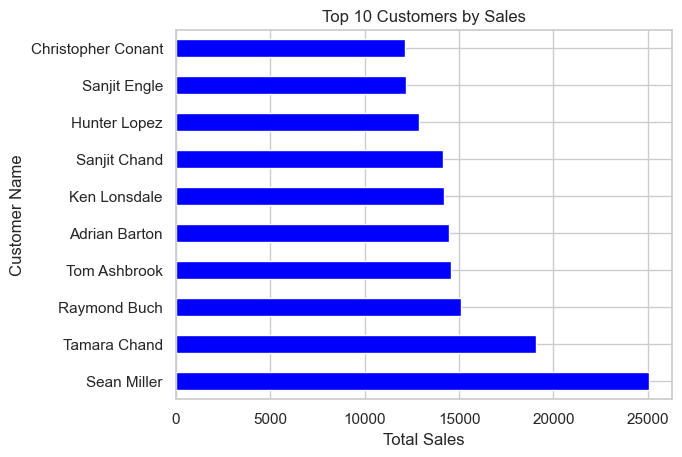

In [60]:
# Top 10 customers by sales
top_customers_sales = orders_customers_merged.groupby('Customer Name')['Sales'].sum().sort_values(ascending=False).head(10)
top_customers_sales.plot(kind='barh', color='Blue')
plt.title('Top 10 Customers by Sales')
plt.xlabel('Total Sales')
plt.ylabel('Customer Name')
plt.show()


In [37]:
merged_df = pd.merge(products_df, orders_df, on='New Product ID', how='inner')


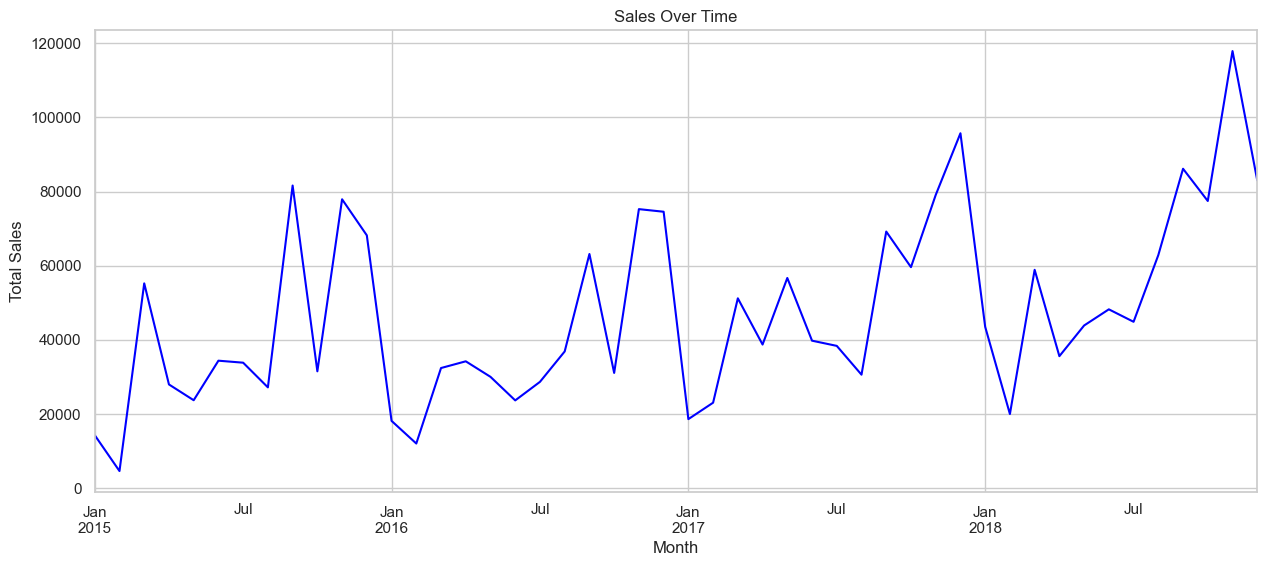

In [38]:
# Purpose: To observe sales trends over time (by day, month, or year).
# Why it’s useful: It helps in understanding seasonality, growth patterns, and sales peaks.
# Sales over time (by month)
orders_df['Order Date'] = pd.to_datetime(orders_df['Order Date'])
sales_over_time = orders_df.groupby(orders_df['Order Date'].dt.to_period('M'))['Sales'].sum()

sales_over_time.plot(kind='line', figsize=(15, 6), color='blue')
plt.title('Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()


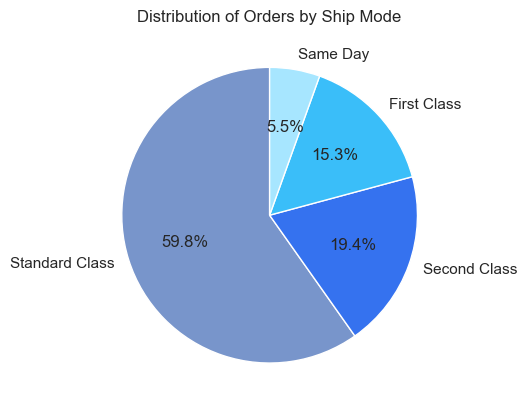

In [63]:
# Purpose: To understand the distribution of shipping modes used by customers.
# Why it’s useful: It shows customer preferences for shipping and can indicate potential cost-saving opportunities or performance issues in shipping methods.
# Pie chart for shipping mode
orders_df['Ship Mode'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#7895CB','#3572EF','#3ABEF9','#A7E6FF'])
plt.title('Distribution of Orders by Ship Mode')
plt.ylabel('')
plt.show()


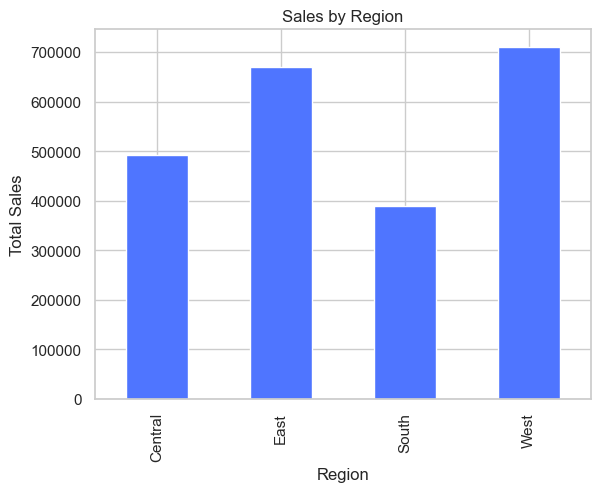

In [65]:
# Purpose: To see which regions or states contribute the most to sales.
# Why it’s useful: This helps in identifying geographic sales performance and optimizing regional marketing strategies.
# Bar chart for sales by region
sales_by_region = orders_df.groupby('Region')['Sales'].sum()

sales_by_region.plot(kind='bar', color='#4F75FF')
plt.title('Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Sales')
plt.show()


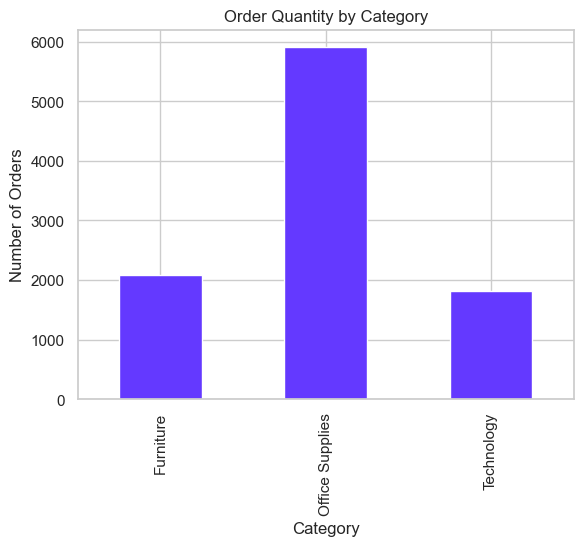

In [66]:
# Purpose: To understand how different product categories perform in terms of the number of orders.
# Why it’s useful: It helps in analyzing which product categories are most popular.
# Bar chart for number of orders by category
orders_by_category = merged_df.groupby('Category').size()

orders_by_category.plot(kind='bar', color='#6439FF')
plt.title('Order Quantity by Category')
plt.xlabel('Category')
plt.ylabel('Number of Orders')
plt.show()


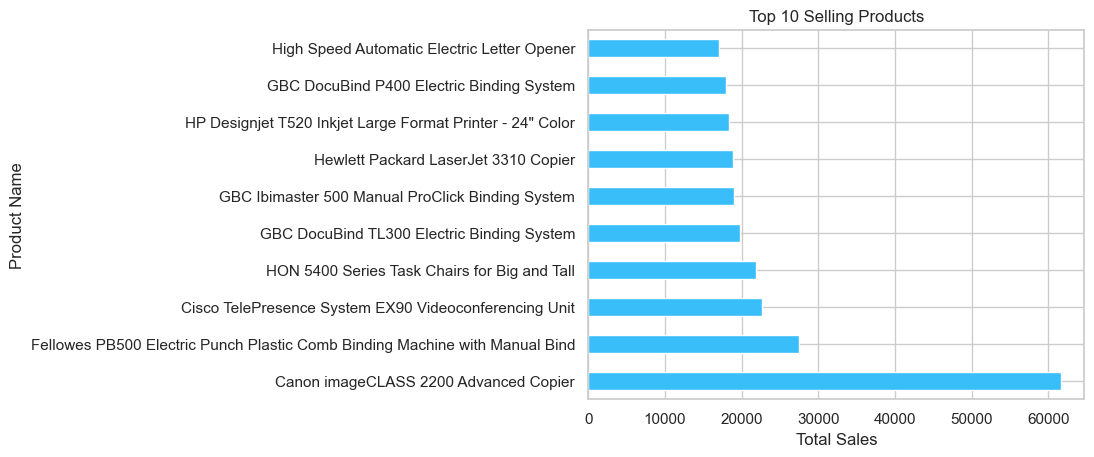

In [67]:
# Purpose: To identify which products generate the highest sales.
# Why it’s useful: It helps prioritize inventory, marketing, and production.
# Top 10 selling products by sales
top_products = merged_df.groupby('Product Name')['Sales'].sum().nlargest(10)

top_products.plot(kind='barh', color='#3ABEF9')
plt.title('Top 10 Selling Products')
plt.xlabel('Total Sales')
plt.ylabel('Product Name')
plt.show()


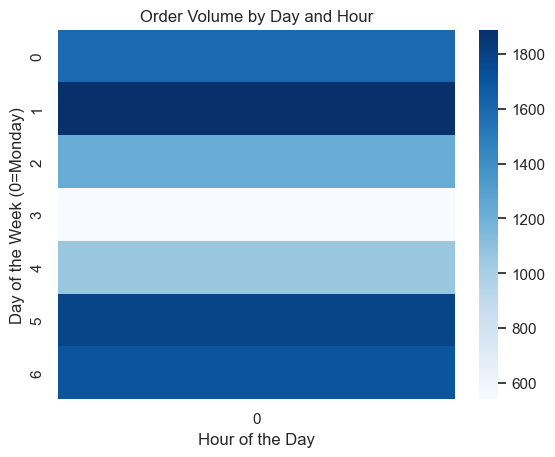

In [69]:
# Heatmap for order volume by hour and day of the week
orders_df['Order Date'] = pd.to_datetime(orders_df['Order Date'])
orders_df['Order Hour'] = orders_df['Order Date'].dt.hour
orders_df['Order Day'] = orders_df['Order Date'].dt.dayofweek

order_volume = orders_df.groupby(['Order Day', 'Order Hour']).size().unstack()

sns.heatmap(order_volume, cmap='Blues', annot=False)
plt.title('Order Volume by Day and Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of the Week (0=Monday)')
plt.show()


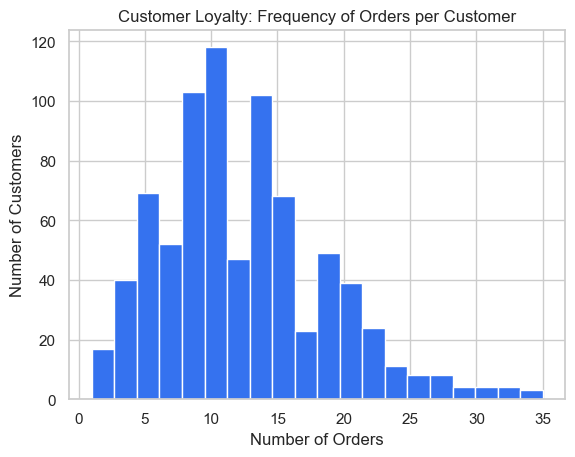

In [68]:
# Histogram for number of orders per customer
orders_per_customer = orders_df.groupby('Customer ID').size()

orders_per_customer.plot(kind='hist', bins=20, color='#3572EF')
plt.title('Customer Loyalty: Frequency of Orders per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.show()


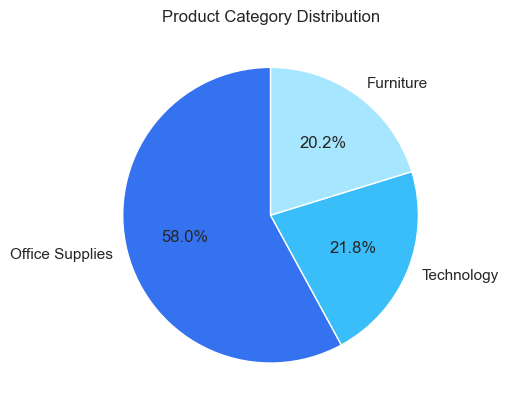

In [70]:
# Purpose: To show the proportion of products in each category.
# Why it’s useful: It helps understand the product mix and inventory focus areas.
# Pie chart for product categories
products_df['Category'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#3572EF','#3ABEF9','#A7E6FF'])
plt.title('Product Category Distribution')
plt.ylabel('')
plt.show()


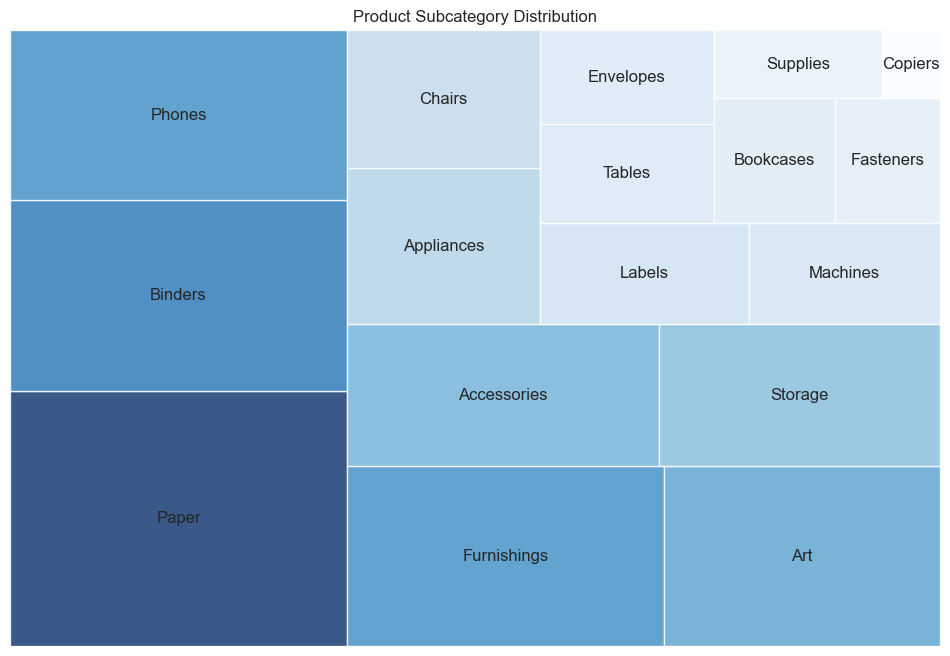

In [73]:
#Purpose: To show the number of products in each subcategory, optionally color-coded by category.
# Why it’s useful: It provides a visual summary of product distribution across subcategories.
  

# Data preparation for treemap
subcategory_counts = products_df['Sub-Category'].value_counts().reset_index()
subcategory_counts.columns = ['Sub-Category', 'Count']

# Generate colors using a blue colormap
norm = plt.Normalize(subcategory_counts['Count'].min(), subcategory_counts['Count'].max())
colors = [cm.Blues(norm(value)) for value in subcategory_counts['Count']]

# Treemap visualization with blue shades
plt.figure(figsize=(12, 8))
squarify.plot(sizes=subcategory_counts['Count'], label=subcategory_counts['Sub-Category'], alpha=0.8, color=colors)
plt.title('Product Subcategory Distribution')
plt.axis('off')
plt.show()


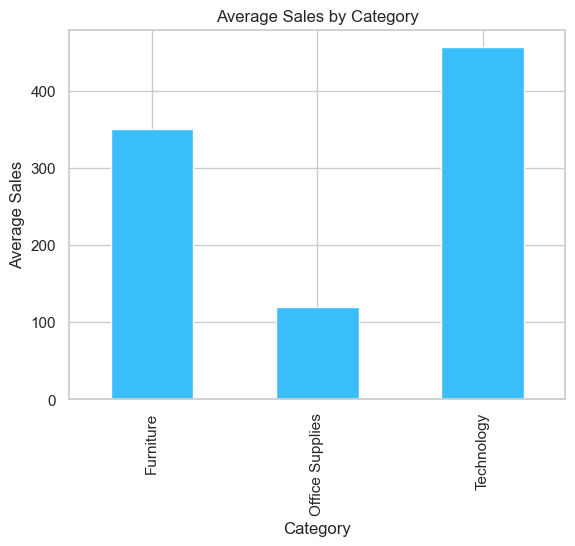

In [74]:
# Calculate average sales by category
merged_df = pd.merge(products_df, orders_df, on='New Product ID', how='inner')
avg_sales_by_category = merged_df.groupby('Category')['Sales'].mean()

# Plot the average sales by category
avg_sales_by_category.plot(kind='bar', color='#3ABEF9')
plt.title('Average Sales by Category')
plt.xlabel('Category')
plt.ylabel('Average Sales')
plt.show()


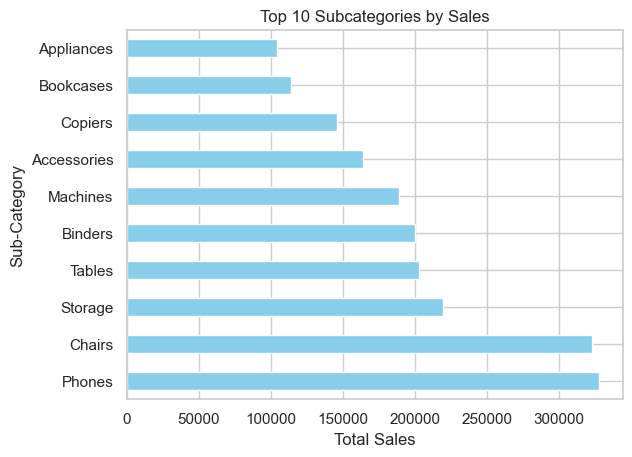

In [48]:
# Assuming 'Sales' is available in the products_df
top_subcategories_by_sales = merged_df.groupby('Sub-Category')['Sales'].sum().nlargest(10)

top_subcategories_by_sales.plot(kind='barh', color='skyblue')
plt.title('Top 10 Subcategories by Sales')
plt.xlabel('Total Sales')
plt.ylabel('Sub-Category')
plt.show()


21:39:41 - cmdstanpy - INFO - Chain [1] start processing
21:39:41 - cmdstanpy - INFO - Chain [1] done processing


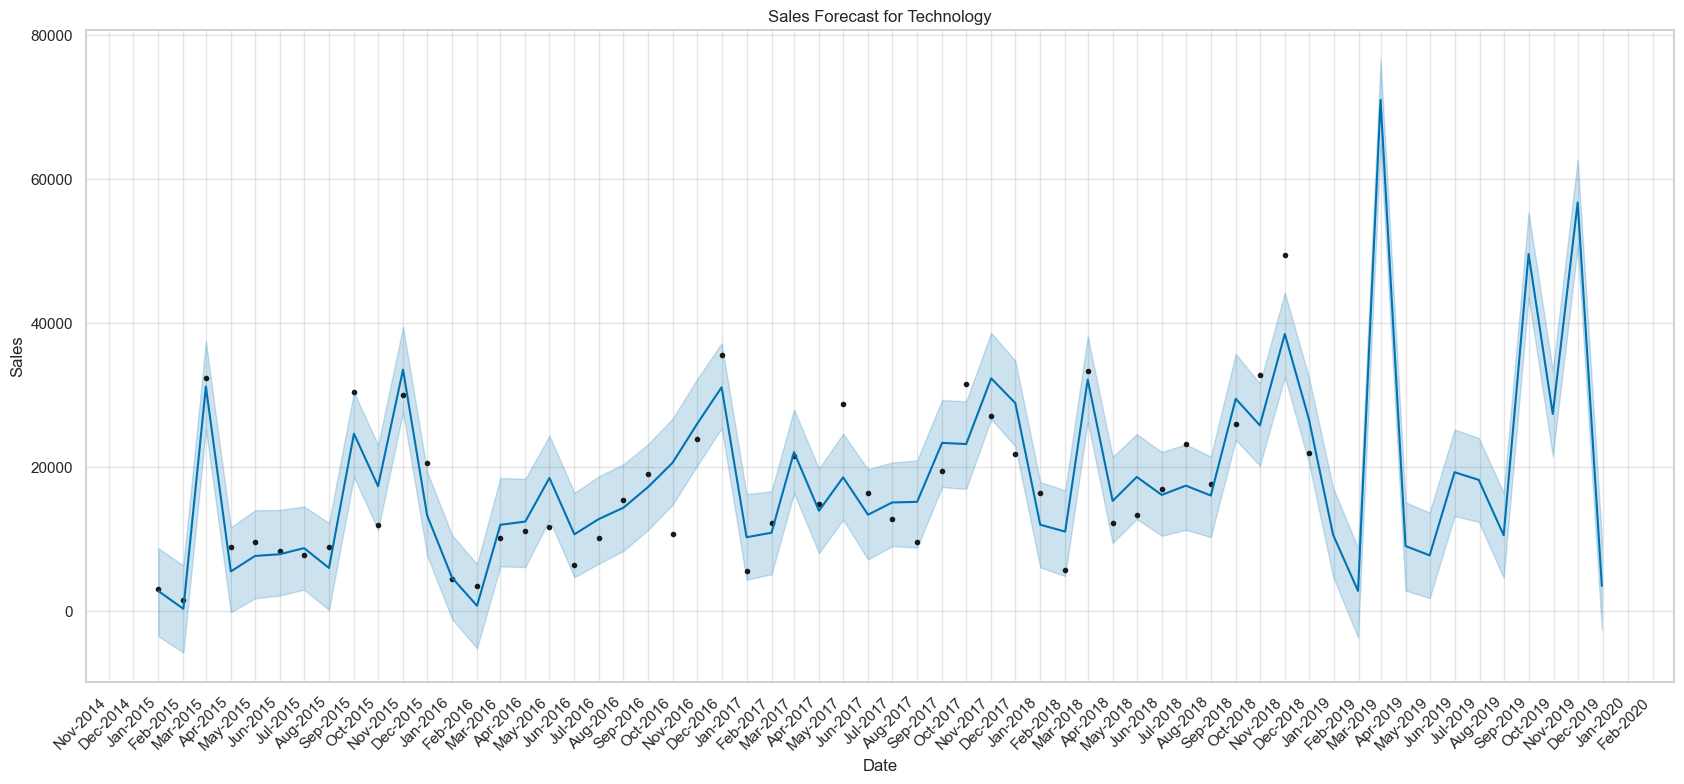

In [49]:
### >>>  Fourth Time Series Forecasting Model.

# For forecasting, let's use the Prophet library by Facebook, which is easy to use for time series data.
# Prepare data for Prophet
# Select a specific category for forecasting
category = 'Technology'  # Change as needed
forecast_data = time_series_data[time_series_data['Category'] == category][['Year-Month', 'Sales']]
forecast_data.columns = ['ds', 'y']
forecast_data['ds'] = forecast_data['ds'].astype(str)

# Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True, daily_seasonality=False)
model.fit(forecast_data)

# Create a dataframe to hold future dates for forecasting
future = model.make_future_dataframe(periods=12, freq='M')  # Forecast for the next 12 months

# Generate the forecast
forecast = model.predict(future)

# Plot the forecast
fig, ax = plt.subplots(figsize=(17, 8))
model.plot(forecast, ax=ax)

# Customize the x-axis to show Month-Year format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  # Format as 'Month-Year'
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to each month

# Rotate and align x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add labels and title
plt.title(f'Sales Forecast for {category}')
plt.xlabel('Date')
plt.ylabel('Sales')

# Show the plot
plt.tight_layout()  # Adjust layout to make space for rotated labels
plt.show()

21:39:43 - cmdstanpy - INFO - Chain [1] start processing
21:39:43 - cmdstanpy - INFO - Chain [1] done processing


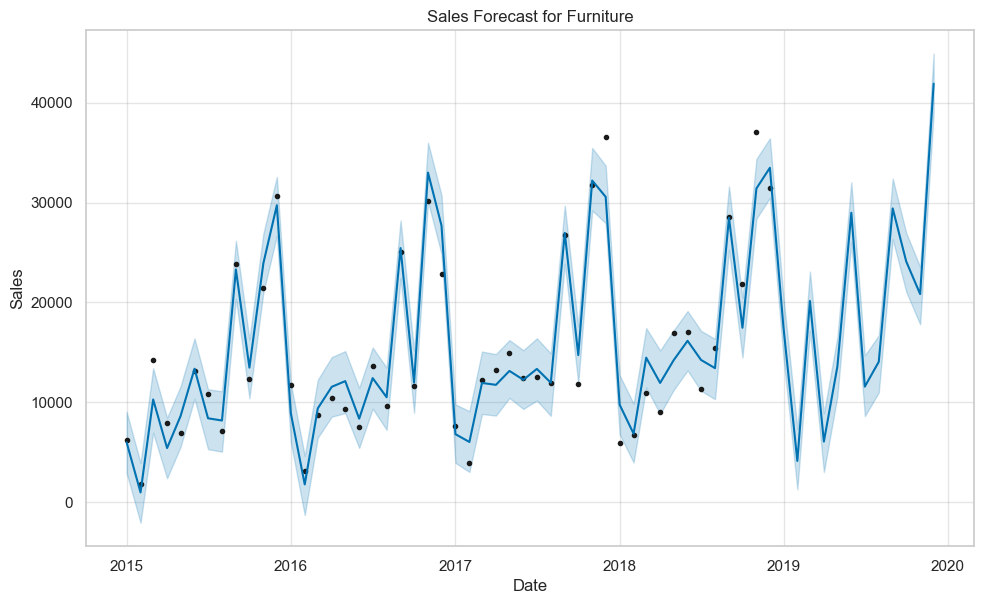

In [50]:
# Prepare data for Prophet
# Select a specific category for forecasting
category = 'Furniture'  # Change as needed
forecast_data = time_series_data[time_series_data['Category'] == category][['Year-Month', 'Sales']]
forecast_data.columns = ['ds', 'y']
forecast_data['ds'] = forecast_data['ds'].astype(str)

# Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True, daily_seasonality=False)
model.fit(forecast_data)

# Create a dataframe to hold future dates for forecasting
future = model.make_future_dataframe(periods=12, freq='M')  # Forecast for the next 12 months

# Generate the forecast
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title(f'Sales Forecast for {category}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing


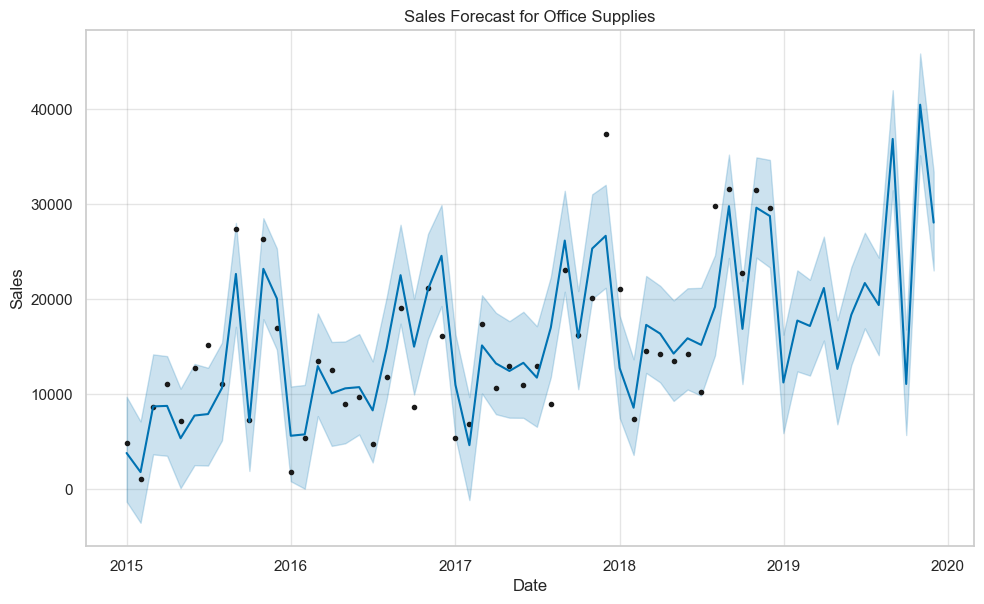

In [51]:
# Prepare data for Prophet
# Select a specific category for forecasting
category = 'Office Supplies'  # Change as needed
forecast_data = time_series_data[time_series_data['Category'] == category][['Year-Month', 'Sales']]
forecast_data.columns = ['ds', 'y']
forecast_data['ds'] = forecast_data['ds'].astype(str)

# Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True, daily_seasonality=False)
model.fit(forecast_data)

# Create a dataframe to hold future dates for forecasting
future = model.make_future_dataframe(periods=12, freq='M')  # Forecast for the next 12 months

# Generate the forecast
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title(f'Sales Forecast for {category}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()


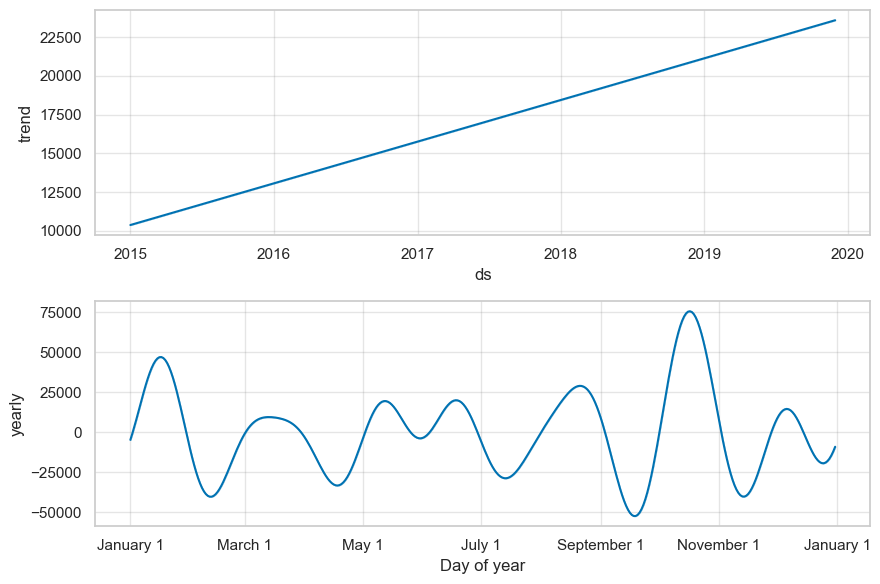

In [52]:
### >>> Fifth and finally Evaluation and Visualization

# Evaluate the model's performance and visualize the forecast versus actual sales data.
# Visualize the forecast components
model.plot_components(forecast)
plt.show()

In [53]:
# Actual sales values for the same period as the forecast
actual_sales = forecast_data['y'].values  # Ensure it's an array
predicted_sales = forecast.loc[:len(actual_sales)-1, 'yhat'].values  # Match the length of actual sales

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_sales, predicted_sales))

# Calculate mean of actual sales
mean_actual_sales = np.mean(actual_sales)

# Calculate RMSE as a percentage of the mean actual sales
rmse_percentage = (rmse / mean_actual_sales) * 100

print(f'RMSE: {rmse:.2f}')
print(f'RMSE Percentage: {rmse_percentage:.2f}%')

RMSE: 4175.56
RMSE Percentage: 28.41%
